<a href="https://colab.research.google.com/github/adityamishra5050/Coronavirus-tweets-NLP---Text-Classification-/blob/main/NLU_ass_1_task4(f).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import re
import copy
import torch.nn as nn
from torch.nn import Embedding
from pathlib import Path

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

from torch import nn,optim
from tqdm.notebook import tqdm

from torch.optim import Adam
# from sklearn.metrics import precision_recall_fscore_support

In [ ]:
Corona_NLP_train=pd.read_csv("/content/drive/MyDrive/Corona_NLP_train.csv",encoding='latin1')

In [ ]:
Corona_NLP_test=pd.read_csv("/content/drive/MyDrive/Corona_NLP_test.csv",encoding='latin1')

In [ ]:
embed_dim = 300

In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

In [ ]:
# word_dictis a mapping dictionary of words to ids，
# <pading>The meaning is to add 0, stands for unknown words, in fact, words that are not in the glove word vector will be considered as<unk>
word_dict = {'<pading>':0,"<unk>": 1}


# Load the glove pre-trained word vector of the corresponding length. The larger the dimension, the slower the loading of the word vector. The 300-dimensional word vector file has1G
glove_path = Path("/content/drive/MyDrive/glove.6B.300d.txt/glove.6B.300d.txt")
glove_df = pd.read_csv(glove_path , sep=" ", quoting=3, header=None, index_col=0)
# Generate the corresponding dictionary form, the key is a word, and the value is a word vector
glove_dict = {key: val.values for key, val in glove_df.T.items()}

In [ ]:
def word_tokenize(text: str):
    """
    This is a function for segmenting words. In addition to simplifying word segmentation, this function，
    It will also complete the word_dict to generate a complete vocabulary mapping
    """
    word_index = []
    pat = re.compile(r"[\w]+|[.,!?;|]")
    tokens = pat.findall(text.lower())
    for token in tokens:
        if token not in word_dict:
            word_dict[token] = len(word_dict) if token in glove_dict else word_dict["<unk>"]
        word_index.append(word_dict[token])
    return word_index

In [ ]:
# Word segmentation of training set and test set
corona_train = Corona_NLP_train["OriginalTweet"].apply(lambda s: word_tokenize(str(s)))
test_text = Corona_NLP_test["OriginalTweet"].apply(lambda s: word_tokenize(str(s)))

In [ ]:
len(word_dict)  # Vocabulary size 85091

85091

In [ ]:
corona_train.apply(lambda x:len(x)).describe()

count    41157.000000
mean        36.377093
std         13.705114
min          1.000000
25%         26.000000
50%         37.000000
75%         47.000000
max        232.000000
Name: OriginalTweet, dtype: float64

In [ ]:
MAX_LENGTH = 240  # maximum sentence length
corona_train = corona_train.apply(lambda x:(x+[0]*MAX_LENGTH)[:MAX_LENGTH])
test_text = test_text.apply(lambda x:(x+[0]*MAX_LENGTH)[:MAX_LENGTH])

In [ ]:
s2i = {'Positive':1,'Extremely Positive':0,'Neutral':2,'Extremely Negative':4,'Negative':3}
Corona_NLP_train['Sentiment']=Corona_NLP_train['Sentiment'].replace(s2i).astype(int)
Corona_NLP_test['Sentiment']=Corona_NLP_test['Sentiment'].replace(s2i).astype(int)

In [ ]:
# The pre-trained word vector matrix, which will be directly input into the embedding layer later
glove_embeddings = np.zeros((len(word_dict), embed_dim))


In [ ]:
class CommentDataset(Dataset):
    def __init__(self,texts,labels):
        self.texts=texts
        self.labels=labels
    def __len__(self):
        return len(self.texts)

    def __getitem__(self,item):
        """
        item For the data index, iterate to fetch item data
        """
        text=torch.tensor(self.texts[item],dtype=torch.long)
        label=torch.tensor(self.labels[item],dtype=torch.long)
        return {'text_id':text,'label':label}
def create_data_loader(X,y,batch_size):
    ds=CommentDataset(
        texts = X.values,
        labels=y.values
    )
    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [ ]:
BATCH_SIZE = 128
corona_train_data_load = create_data_loader(corona_train,Corona_NLP_train['Sentiment'], BATCH_SIZE)
corona_val_data_load = create_data_loader(test_text,Corona_NLP_test['Sentiment'], BATCH_SIZE)

In [ ]:
next(iter(corona_train_data_load))

{'text_id': tensor([[   1,    1,    1,  ...,    0,    0,    0],
         [  13,   14,   15,  ...,    0,    0,    0],
         [  46,   47,   48,  ...,    0,    0,    0],
         ...,
         [  36,    1,  421,  ...,    0,    0,    0],
         [1496,   63, 1497,  ...,    0,    0,    0],
         [   1,   78,  281,  ...,    0,    0,    0]]),
 'label': tensor([2, 1, 1, 1, 4, 1, 1, 2, 1, 3, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 4, 2, 0, 0,
         3, 0, 3, 4, 3, 4, 3, 0, 2, 0, 3, 2, 1, 1, 3, 1, 0, 1, 4, 2, 2, 3, 0, 1,
         0, 2, 4, 2, 3, 1, 4, 0, 4, 1, 0, 2, 3, 2, 1, 0, 2, 4, 3, 3, 1, 1, 2, 1,
         2, 2, 1, 0, 4, 3, 4, 1, 1, 1, 4, 3, 4, 1, 3, 2, 3, 0, 0, 3, 3, 0, 1, 0,
         1, 1, 1, 3, 4, 3, 0, 1, 4, 0, 1, 4, 2, 1, 1, 1, 3, 1, 4, 1, 3, 1, 3, 1,
         4, 0, 3, 1, 0, 4, 4, 3])}

In [ ]:
class Model(nn.Module):
    def __init__(self,weight, embed_dim=300):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weight,freeze=False)  #_______________Still training word vectors
        self.Linear = nn.Linear(embed_dim,5)
    def forward(self, X):
        X = self.embedding(X)   # _______________________________________________________[b,240] ==> [b,240,300]
        X = X.mean(dim=1)       # _______________________________________________________[b,240] ==> [b,300]
        out = self.Linear(X)    # _______________________________________________________[b,300] ==> [b,5]
        return out

class GRUModel(nn.Module):
    def __init__(self,weight, embed_dim=300,hidden_size=512):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weight,freeze=False)  # Still training word vectors
        self.rnn = nn.GRU(300,hidden_size,batch_first=True,num_layers=2,bidirectional=True,dropout=0.3)
        self.linear = nn.Linear(hidden_size*2,hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(hidden_size,5)
    def forward(self, X):
        X = self.embedding(X) # [b,240] ==> [b,240,300]
        X,_ = self.rnn(X)     #  [b,240,300] ==>  [b, 240, hidden_size*2]
        X = self.dropout(self.linear(X)) # [b, 240, hidden_size*2] ==> [b, 240, hidden_size]
        X = X.mean(dim=1)  # [b, 240, hidden_size] ==> [b,hidden_size]
        out = self.out(X) # [b,hidden_size] ==> [b,5]
        return out

In [ ]:
from collections import defaultdict
history = defaultdict(list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Set up CUDA
Number_of_epochs = 3     # Set the number of model training times
Lr_rate = 3e-4  # initial learning rate

model= GRUModel(torch.from_numpy(glove_embeddings).float())
model = model.to(device)
# optimizer
optimizer = Adam(model.parameters(),Lr_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)
for epoch in tqdm(range(Number_of_epochs)):
    #Enable training mode for the model
    model.train()
    # Define loss
    loss_of_epoch = 0
    accuracy_of_epoch = 0
    validation_no = 0
    for batch in corona_train_data_load:
        text_id = batch['text_id'].to(device)
        label = batch['label'].to(device)
        predictions = model(text_id)
        loss = criterion(predictions, label)
        loss_of_epoch += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        preds = predictions.max(1)[1]
        accuracy_of_epoch += ((preds==label).sum().item())
        validation_no += label.size(0)
    history['train_loss'].append(loss_of_epoch / len(corona_train_data_load))
    history['train_accuracy'].append(accuracy_of_epoch / validation_no)
    print(f'No.{epoch+1}wheel，trainLoss：',loss_of_epoch / len(corona_train_data_load),'，training accuracy：',accuracy_of_epoch / validation_no)

    model.eval()
    # initialization loss
    loss_of_epoch = 0
    accuracy_of_epoch = 0
    validation_no = 0

    #do not compute gradients
    with torch.no_grad():
        for batch in corona_val_data_load:
            text_id = batch['text_id'].to(device)
            label = batch['label'].to(device)
            predictions = model(text_id)
            loss = criterion(predictions, label)
            loss_of_epoch += loss.item()
            preds = predictions.max(1)[1]
            accuracy_of_epoch += ((preds==label).sum().item())
            validation_no += label.size(0)
    history['test_loss'].append(loss_of_epoch / len(corona_val_data_load))
    history['test_accuracy'].append(accuracy_of_epoch / validation_no)
    print(f'No.{epoch+1}wheel,testLoss：',loss_of_epoch / len(corona_val_data_load),'，test accuracy：',accuracy_of_epoch / validation_no)
    print('-'*20)

  0%|          | 0/3 [00:00<?, ?it/s]

No.1wheel，trainLoss： 1.4084652834427283 ，training accuracy： 0.3749544427436402
No.1wheel,testLoss： 1.1523190100987752 ，test accuracy： 0.5250131648235914
--------------------
No.2wheel，trainLoss： 0.8014014341075968 ，training accuracy： 0.7018976115849066
No.2wheel,testLoss： 0.7583661198616027 ，test accuracy： 0.731437598736177
--------------------
No.3wheel，trainLoss： 0.5343843768842472 ，training accuracy： 0.8147581213402337
No.3wheel,testLoss： 0.7021308382352193 ，test accuracy： 0.7601369141653502
--------------------


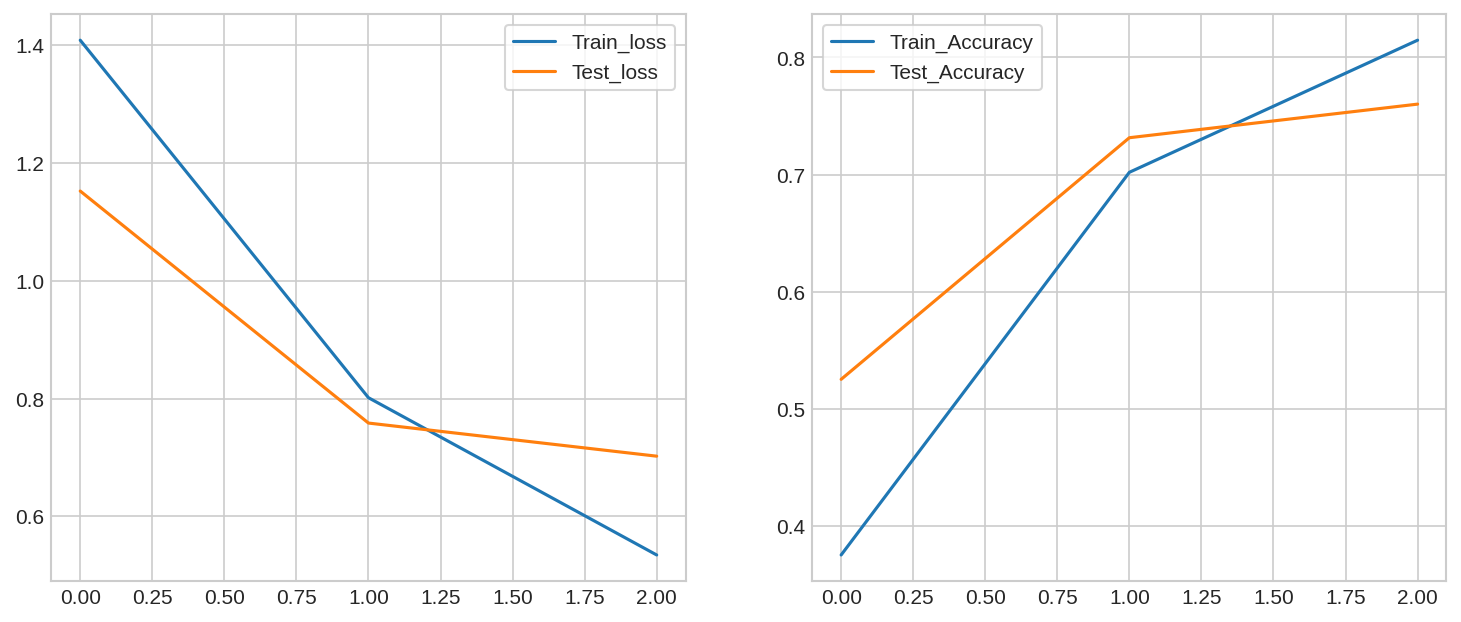

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,5),dpi=150)
plt.subplot(1,2,1)
plt.plot(history['train_loss'],label='Train_loss')
plt.plot(history['test_loss'],label='Test_loss')
plt.legend(frameon=True)

plt.subplot(1,2,2)
plt.plot(history['train_accuracy'],label='Train_Accuracy')
plt.plot(history['test_accuracy'],label='Test_Accuracy')
plt.legend(frameon=True)

plt.show()